In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/5955.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/16694.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/4548.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/16634.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/5788.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/11956.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/13160.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/6947.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/8600.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/7559.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/16628.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/14057.npy
/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/4821.npy
/kaggl

# Preprocess the images

0 = No clouds or missing data 1 = Very low clouds 2 = Low clouds 3 = Mid-level clouds 4 = High opaque clouds 5 = Very high opaque clouds 6 = Fractional clouds 7 = High semitransparant thin clouds 8 = High semitransparant moderately thick clouds 9 = High semitransparant thick clouds 10 = High semitransparant above low or medium clouds

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2025-07-26 14:16:26.249859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753539386.404807     938 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753539386.447511     938 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = 64
input_seq_len = 10
num_classes = 11

In [3]:
def load_npy_folder(folder_path):
    files = sorted(os.listdir(folder_path))  # ensure time order
    files = [f for f in files if f.endswith('.npy')]
    print(len(files))
    half_files = files[:len(files)//5]  
    
    frames = []
    for file in half_files:
        frame = np.load(os.path.join(folder_path, file))  # shape: (728, 728)
        frames.append(frame)
    
    return np.stack(frames)  # shape: (N, 728, 728)

In [4]:
train_frames = load_npy_folder("/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TrainCloud")
test_frames = load_npy_folder("/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud")

52417
17665


In [5]:
train_frames[0][0]

array([  1,   1,   3,   3,   3,   3,   3,   3,   3,   3,   3,   2,   2,
         2,   2,   2, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,
       251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,
       251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,
       251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,
       251, 251, 251, 251, 251, 251,   4,   4,   4,   4,   3,   4,   4,
         3,   6,   3,   6,   8,   6,   1,   1,   1,   1,   1,   1,   1,
         1,   0,   0,   1,   1,   6,   6,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   7,   7,   7,   7,   6,   7,   6,   6,   6,
         7,   6,   6,   6,   6,   6,   7,   6,   6,   6,   6], dtype=int32)

In [6]:
train_frames[train_frames == 251] = 0
test_frames[test_frames == 251] = 0

In [7]:
train_frames[0][0]

array([1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 4, 3, 4, 4, 3, 6, 3, 6, 8, 6, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7,
       7, 7, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6], dtype=int32)

In [42]:
test_frames.shape

(3533, 128, 128)

In [8]:
# to resize the label to (128,128)
def resize_frames(X, img_size):
    return tf.image.resize(tf.expand_dims(X, -1), (img_size, img_size)).numpy().astype(np.uint8)

In [9]:
train_resized = resize_frames(train_frames, img_size)
test_resized = resize_frames(test_frames, img_size)

I0000 00:00:1753539492.796211     938 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753539492.796873     938 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
train_resized.shape

(10483, 64, 64, 1)

In [11]:
# creating sequence
def create_sequences(X, input_len=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - input_len):
        X_seq.append(X[i:i+input_len])
        y_seq.append(X[i+input_len])
    return np.array(X_seq), np.array(y_seq)

In [12]:
xtrain,ytrain = create_sequences(train_resized,10)

In [13]:
ytrain.shape

(10473, 64, 64, 1)

In [14]:
xtrain.shape

(10473, 10, 64, 64, 1)

In [15]:
xtest,ytest = create_sequences(test_resized,10)

In [16]:
ytest.shape

(3523, 64, 64, 1)

In [17]:
# Normalizng the inputs
xtrain = xtrain/10.0
xtest = xtest/10.0

In [18]:
xtrain[0][0]

array([[[0.1],
        [0.3],
        [0.3],
        ...,
        [0.6],
        [0.6],
        [0.6]],

       [[0.1],
        [0.3],
        [0.3],
        ...,
        [0.6],
        [0.6],
        [0.6]],

       [[0.3],
        [0.3],
        [0.3],
        ...,
        [0.6],
        [0.7],
        [0.8]],

       ...,

       [[0. ],
        [0. ],
        [0.1],
        ...,
        [0. ],
        [0.3],
        [0. ]],

       [[0.1],
        [0.4],
        [0.5],
        ...,
        [0. ],
        [0. ],
        [0.3]],

       [[0.5],
        [0.5],
        [0.3],
        ...,
        [0. ],
        [0.2],
        [0.1]]])

In [19]:
# to make the test sequences to one hot encoded 
# if 7 comes then 0 , 0  , 0 , 0 , 0 ,0,1,0,0,0,0
ytrain = tf.one_hot(ytrain.squeeze(-1), depth=num_classes)
ytest  = tf.one_hot(ytest.squeeze(-1), depth=num_classes)

In [20]:
ytest.shape

TensorShape([3523, 64, 64, 11])

In [21]:
ytrain.shape

TensorShape([10473, 64, 64, 11])

# Model Building using CONVLSTM 

In [22]:
from tensorflow.keras import layers , models

In [26]:
# this one to build the model
def build_cloud_predictor(img_size=128, input_seq_len=10, num_classes=11):
    model = models.Sequential([
        layers.Input(shape=(input_seq_len, img_size, img_size, 1)),

        # ConvLSTM2D layer to learn spatiotemporal patterns
        layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, activation='relu'),

        layers.BatchNormalization(),

        # Output layer: 1 frame with 11 class probabilities per pixel
        layers.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax')  # per-pixel classification
    ])
    return model

In [27]:
model = build_cloud_predictor(img_size = 64 , input_seq_len = 5 , num_classes= 11)

In [28]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 64, 64, 64)     │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 11)     │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,987 (589.79 KB)

 Trainable params: 150,859 (589.29 KB)

 Non-trainable params: 128 (512.00 B)

In [30]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=5)

Epoch 1/5


I0000 00:00:1753534173.608968     250 service.cc:148] XLA service 0x79f7a4025f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753534173.609585     250 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753534173.609605     250 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753534174.051911     250 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/328 ━━━━━━━━━━━━━━━━━━━━ 40:24 7s/step - accuracy: 0.0500 - loss: 2.6895

I0000 00:00:1753534177.406305     250 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 ━━━━━━━━━━━━━━━━━━━━ 76s 209ms/step - accuracy: 0.4251 - loss: 1.6825 - val_accuracy: 0.4689 - val_loss: 1.7572
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.5186 - loss: 1.3693 - val_accuracy: 0.5229 - val_loss: 1.3515
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.5285 - loss: 1.3392 - val_accuracy: 0.5342 - val_loss: 1.3146
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.5319 - loss: 1.3317 - val_accuracy: 0.5401 - val_loss: 1.3052
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.5370 - loss: 1.3142 - val_accuracy: 0.5452 - val_loss: 1.2907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


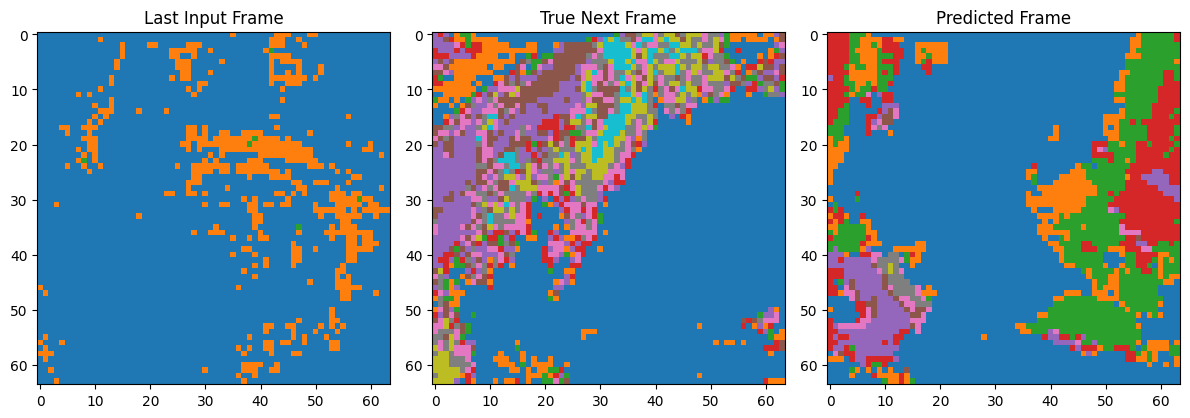

In [31]:
sample_input = xtest[0:1]  # shape: (1, 10, 128, 128, 1)
true_next_frame = tf.argmax(ytest[0], axis=-1).numpy()  # (128, 128)

# Predict next frame
pred = model.predict(sample_input)  # (1, 128, 128, 11)
predicted_frame = tf.argmax(pred[0], axis=-1).numpy()  # (128, 128)

# Visualize
plt.figure(figsize=(12, 4))

# Last input frame
plt.subplot(1, 3, 1)
plt.imshow(sample_input[0, -1, :, :, 0], cmap='tab10', vmin=0, vmax=10)
plt.title("Last Input Frame")

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(true_next_frame, cmap='tab10', vmin=0, vmax=10)
plt.title("True Next Frame")

# Prediction
plt.subplot(1, 3, 3)
plt.imshow(predicted_frame, cmap='tab10', vmin=0, vmax=10)
plt.title("Predicted Frame")

plt.tight_layout()
plt.show()

In [23]:
img_size = 64  # or 128
input_seq_len = 10

model_new = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, img_size, img_size, 1)),
    layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=False, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(num_classes, (1, 1), activation='softmax')
])


In [24]:
model_new.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [25]:
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 64, 64, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 64, 64, 32)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 11)     │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,467 (513.54 KB)

 Trainable params: 131,339 (513.04 KB)

 Non-trainable params: 128 (512.00 B)

In [26]:
model_new.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=5)

Epoch 1/5


I0000 00:00:1753539510.728178     972 service.cc:148] XLA service 0x61789180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753539510.729319     972 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753539510.729347     972 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753539511.496676     972 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753539515.971796     972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 ━━━━━━━━━━━━━━━━━━━━ 191s 546ms/step - accuracy: 0.4612 - loss: 1.5275 - val_accuracy: 0.1019 - val_loss: 2.4114
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 172s 525ms/step - accuracy: 0.5278 - loss: 1.2754 - val_accuracy: 0.4938 - val_loss: 1.3251
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 173s 527ms/step - accuracy: 0.5355 - loss: 1.2421 - val_accuracy: 0.5371 - val_loss: 1.2149
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 173s 526ms/step - accuracy: 0.5402 - loss: 1.2242 - val_accuracy: 0.5496 - val_loss: 1.2327
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 173s 527ms/step - accuracy: 0.5463 - loss: 1.2070 - val_accuracy: 0.5594 - val_loss: 1.1574


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


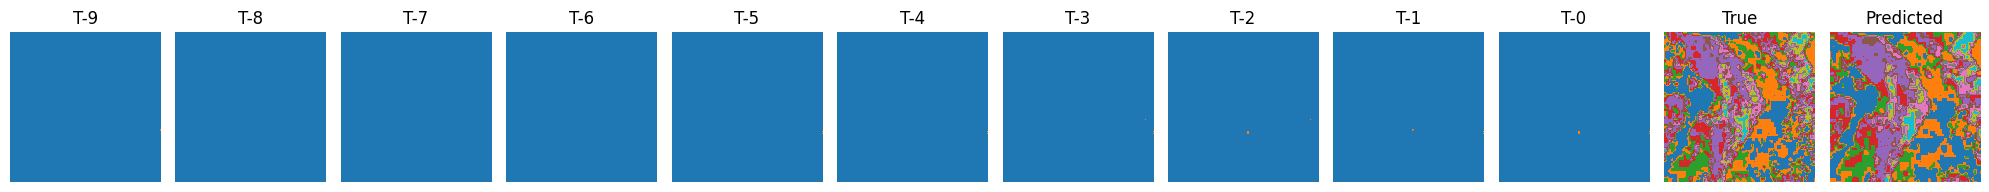

In [41]:
sample_index = 3000

# Extract input sequence and true output frame
sample_input = xtest[sample_index:sample_index+1]  # (1, 10, 64, 64, 1)
true_next_frame = tf.argmax(ytest[sample_index], axis=-1).numpy()  # (64, 64)

# Predict using your trained model
pred = model_new.predict(sample_input)  # (1, 64, 64, 11)
predicted_frame = tf.argmax(pred[0], axis=-1).numpy()  # (64, 64)

# 📊 Plot the 10 input frames + true and predicted frames
fig, axes = plt.subplots(1, 12, figsize=(20, 3))

# Show all 10 frames in the sequence
for i in range(10):
    axes[i].imshow(sample_input[0, i, :, :, 0], cmap='tab10', vmin=0, vmax=10)
    axes[i].set_title(f"T-{9 - i}")
    axes[i].axis('off')

# Ground truth next frame
axes[10].imshow(true_next_frame, cmap='tab10', vmin=0, vmax=10)
axes[10].set_title("True")
axes[10].axis('off')

# Predicted next frame
axes[11].imshow(predicted_frame, cmap='tab10', vmin=0, vmax=10)
axes[11].set_title("Predicted")
axes[11].axis('off')

plt.tight_layout()
plt.show()

In [55]:
def get_frames_for_prediction(directory_path, i, num_previous_frames=10):
    """
    Given a directory path and an index `i`, this function will return the 10 previous frames
    and 1 future frame for prediction.
    
    Args:
    - directory_path (str): Path to the directory containing the .npy files.
    - i (int): The index for the future frame.
    - num_previous_frames (int): Number of previous frames to return.
    
    Returns:
    - X: A sequence of 10 previous frames, shape: (10, height, width)
    - y: The next (future) frame, shape: (height, width)
    """
    
    # List and sort the files in the directory
    files = sorted(os.listdir(directory_path))
    files = [f for f in files if f.endswith('.npy')]  # Only consider .npy files
    
    # Ensure index `i` has at least `num_previous_frames` previous frames
    if i < num_previous_frames:
        raise ValueError(f"Index {i} is too small to extract {num_previous_frames} previous frames.")
    
    # Get the range of file indices
    file_indices = files[i - num_previous_frames: i + 1]  # Last 10 frames and the future frame
    
    # Load the frames into a list
    frames = [np.load(os.path.join(directory_path, file)) for file in file_indices]
    
    # Separate the 10 previous frames and the 1 future frame
    X = np.array(frames[:-1])  # Shape: (10, height, width)
    y = frames[-1]  # The future frame (1 frame)
    
    return X, y
    

# Example usage:
dir_path = '/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud'

# For example, we want to get frames for index 1000
i = 1000
X, y = get_frames_for_prediction(dir_path, i)

# Verify the output
print("Shape of X (previous frames):", X.shape)
print("Shape of y (future frame):", y.shape)

Shape of X (previous frames): (10, 128, 128)
Shape of y (future frame): (128, 128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


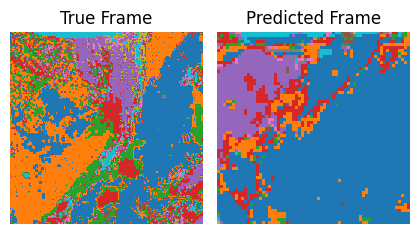

In [61]:
img_size = 64  # The input frame size
input_seq_len = 10  # Number of frames to predict the next frame
num_classes = 11  # Number of classes for per-pixel classification

# Load the sequence of .npy files (10 frames)
def load_npy_files(file_paths):
    frames = []
    for file_path in file_paths:
        frame = np.load(file_path)  # Load each frame (128, 128)
        frames.append(frame)
    return np.array(frames)  # Shape: (10, 128, 128)

# Directory path to the files
dir = '/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TestCloud/'

# List of file names
npy_file_paths = ['10010.npy','10011.npy', '10012.npy', '10013.npy', '10014.npy', '10015.npy', 
                  '10016.npy', '10017.npy', '10018.npy', '10019.npy']

# Combine directory path with file names to get the full paths
full_file_paths = [os.path.join(dir, file) for file in npy_file_paths]

# Load the frames from the .npy files
input_sequence = load_npy_files(full_file_paths)  # Shape: (10, 128, 128)

# Preprocess the input sequence
# Resize the frames to (64, 64) and reshape to (1, 10, 64, 64, 1)
sample_input = tf.image.resize(tf.expand_dims(input_sequence, axis=-1), (img_size, img_size)).numpy().astype(np.uint8)  # Shape: (10, 64, 64, 1)
sample_input = np.expand_dims(sample_input, axis=0)  # Shape: (1, 10, 64, 64, 1)
sample_input = sample_input / 10.0  # Normalize the input (if required)

# Make the prediction using the trained ConvLSTM model
predicted_frame = model_new.predict(sample_input)  # Shape: (1, 128, 128, 11)

# Post-process the prediction (convert to class labels)
predicted_frame = np.argmax(predicted_frame[0], axis=-1)  # Shape: (128, 128)

# Visualize the input frames, predicted frame, and true frame
plt.figure(figsize=(25, 20))

# Show the last 10 input frames (T-9 to T-0)
# for i in range(10):
#     plt.subplot(1, 12, i + 1)
#     plt.imshow(sample_input[0, i, :, :, 0], cmap='tab10', vmin=0, vmax=10)
#     plt.title(f"T-{9 - i}")
#     plt.axis('off')

# Load the true next frame from TrainCloud (or the corresponding ground truth)
true_next_frame = np.load('/kaggle/input/the-cloudcast-dataset-small/CloudCastSmall/TrainCloud/1002.npy')  # Ensure correct path

# Show the true next frame (ground truth)
plt.subplot(1, 12, 11)  # Use subplot 11 for the true next frame
plt.imshow(true_next_frame, cmap='tab10', vmin=0, vmax=10)
plt.title("True Frame")
plt.axis('off')

# Show the predicted next frame
plt.subplot(1, 12, 12)  # Use subplot 12 for the predicted frame
plt.imshow(predicted_frame, cmap='tab10', vmin=0, vmax=10)
plt.title("Predicted Frame")
plt.axis('off')

plt.tight_layout()
plt.show()